In [1]:
import pandas as pd

In [2]:
dataset2 = pd.read_csv('Dataset/Dataset_02.csv')

In [4]:
print(dataset2.columns)
print(dataset2.dtypes)
print(dataset2.shape)

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')
Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object
(200, 6)


In [5]:
dataset2

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


1. 해당 데이터에 대한 EDA를 수행하고, 여성으로 혈합이 High, cholesterol이 Normal인 환자의 전체에 댛비한 비율이 얼마인지 소수점 네 번째 자리에서 반올림하여 기술하시오

In [8]:
# 구성비율로 교차표 만들기 : pd.crosstab(normalize=True)

pd.crosstab(index=[dataset2.Sex, dataset2.BP],
            columns=dataset2.Cholesterol,
           normalize=True)

# 정답 : 0.105

Cholesterol   HIGH  NORMAL
Sex BP                    
F   HIGH     0.085   0.105
    LOW      0.070   0.070
    NORMAL   0.090   0.060
M   HIGH     0.090   0.105
    LOW      0.085   0.095
    NORMAL   0.095   0.050

In [16]:
import numpy as np
# pivot table 이용방법

pd.pivot_table(data=dataset2,
                index=['Sex', 'BP'],
               columns=['Cholesterol'],
              values=['Drug'], 
              aggfunc='count')/len(dataset2)

Drug       
Cholesterol   HIGH NORMAL
Sex BP                   
F   HIGH     0.085  0.105
    LOW      0.070  0.070
    NORMAL   0.090  0.060
M   HIGH     0.090  0.105
    LOW      0.085  0.095
    NORMAL   0.095  0.050

---

In [17]:
# 변수 생성 후 카이스퀘어 검정
import numpy as np

Q2 = dataset2.copy()

# 방법 1
Q2['Age_gr']=np.where(Q2.Age<20, '10',
                      np.where(Q2.Age<30, '20',
                              np.where(Q2.Age<40, '30',
                                      np.where(Q2.Age<50, '40',
                                              np.where(Q2.Age<60, '50', '60')))))

# 방법 2
pd.cut(Q2.Age, [0, 20, 30, 40, 50, 60, Q2.Age.max()+1],
       right=False,
       labels=['10', '20', '30', '40', '50', '60'])

0      20
1      40
2      40
3      20
4      60
       ..
195    50
196    10
197    50
198    20
199    40
Name: Age, Length: 200, dtype: category
Categories (6, object): ['10' < '20' < '30' < '40' < '50' < '60']

2. Na_k_gr 컬럼을 만들고 Na_to_k 값이 10이하는 'Lv1', 20이하는 'Lv2', 20이하는 'Lv3', 30초과는 'Lv4'로 변환하시오

In [19]:
Q2['Na_k_gr'] = np.where(Q2['Na_to_K'] <= 10, 'Lv1',
                        np.where(Q2['Na_to_K'] <= 20, 'Lv2',
                                np.where(Q2['Na_to_K'] <= 30, 'Lv3','Lv4')))

In [21]:
import scipy.stats as sc

In [25]:
# 카이스퀘어 검정
# 입력 값이 빈도 테이블로 들어가도록 변경
# ['Sex', 'BP', 'Cholesterol', 'Age_gr','Na_k_gr','Drug']

Age_t = pd.crosstab(Q2.Age_gr, Q2.Drug)
out_Age_t = sc.chi2_contingency(Age_t)

# [1] => p-value
print(out_Age_t[1])

0.0007010113024729462


In [33]:
Q2_temp=[]
for i in ['Sex', 'BP', 'Cholesterol', 'Age_gr','Na_k_gr']:
    temp=pd.crosstab(Q2[i], Q2.Drug)
    out_Age_t=sc.chi2_contingency(temp)
    print(i, out_Age_t[1])
    Q2_temp = Q2_temp + [[i, out_Age_t[1]]]
    
Q2_temp=pd.DataFrame(Q2_temp)

Q2_temp.columns = ['var', 'pvalues']
Q2_temp2 = Q2_temp[Q2_temp.pvalues < 0.05]
len(Q2_temp2)

Q2_temp2.sort_values(by='pvalues').tail(1)

# 정답 : Age_gr 0.000701

Sex 0.7138369773987128
BP 5.0417334144665895e-27
Cholesterol 0.0005962588389856497
Age_gr 0.0007010113024729462
Na_k_gr 1.1254641594413981e-14


,var,pvalues
3,Age_gr,0.000701


---

3. sex, bp, cholesterol 등 세 개의 변수를 다음과 같이 변환하고 의사결정나무 이용

- sex는 M을 0 F를 1로 변환하여 Sex_cd 변수 생성
- BP는 Low는 0, Normal은 1 그리고 High는 2로 변환하여 BP_cd 변수 생성
- Cholesterol은 Normal은 0, High는 1로 변환하여 ch_cd 생성
- age, Na_to_k, Sex_cd, BP_cd, ch_rd를 Feature로 Drug을 Label로 하여 의사결정나무를 수행하고 Root Node의 Split feature와 split_value를 기술

In [34]:
import numpy as np # np.where
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [36]:
ds = dataset2.copy()

In [63]:
ds['Sex_cd'] = np.where(ds['Sex'] == 'M', 0 ,1)
ds['BP_dc'] = np.where(ds['BP'] =='LOW', 0,
                      np.where(ds['BP'] =='NORMAL', 1, 2))
ds['ch_cd'] = np.where(ds['Cholesterol']=='NORMAL', 0, 1)

In [69]:
ds

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Sex_cd,BP_dc,ch_cd
0,23,F,HIGH,HIGH,25.355,DrugY,1,2,1
1,47,M,LOW,HIGH,13.093,drugC,0,0,1
2,47,M,LOW,HIGH,10.114,drugC,0,0,1
3,28,F,NORMAL,HIGH,7.798,drugX,1,1,1
4,61,F,LOW,HIGH,18.043,DrugY,1,0,1
...,...,...,...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC,1,0,1
196,16,M,LOW,HIGH,12.006,drugC,0,0,1
197,52,M,NORMAL,HIGH,9.894,drugX,0,1,1
198,23,M,NORMAL,NORMAL,14.020,drugX,0,1,0


'|--- Na_to_K <= 14.829\n|   |--- BP_dc <= 1.500\n|   |   |--- BP_dc <= 0.500\n|   |   |   |--- ch_cd <= 0.500\n|   |   |   |   |--- class: drugX\n|   |   |   |--- ch_cd >  0.500\n|   |   |   |   |--- class: drugC\n|   |   |--- BP_dc >  0.500\n|   |   |   |--- class: drugX\n|   |--- BP_dc >  1.500\n|   |   |--- Age <= 50.500\n|   |   |   |--- class: drugA\n|   |   |--- Age >  50.500\n|   |   |   |--- class: drugB\n|--- Na_to_K >  14.829\n|   |--- class: DrugY\n'

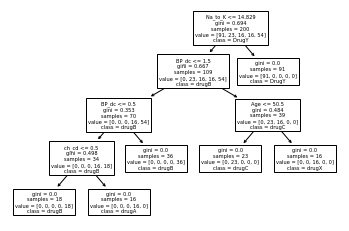

In [72]:
x_var = ['Age', 'Na_to_K', 'Sex_cd', 'BP_dc', 'ch_cd']

dt=DecisionTreeClassifier().fit(ds[x_var], ds.Drug)

plot_tree(dt, feature_names=x_var, class_names=ds.Drug.unique())
export_text(dt, feature_names=x_var, decimals=3)

# 정답 : Na_to_K , 14.829